## Scaling estimates figure

In [1]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('paper')
sns.set_style('white')

In [3]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [4]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh=97.5 # head depth
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Phi(U=0.37,f=9.66E-5,L=6400,R=5000.0,Wsb=13000,N=0.0055):
    ''' flux of upwelling as in Allen and Hickey 2010 , with expected coef of 1/4'''
    f2 = (0.9**(1.5))*((Ro(U,f,R))/(1+(Ro(U,f,R)/0.9)))**(1.5)
    f3 = Ro(U,f,L)**(0.5)
    return(f2*f3)

In [5]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [11]:
select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

for ind in select_rec:
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    
    
    #file = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(records[ind].exp_code,records[ind].run_num))
    #         +'advTracer_CS_transports.nc')
    #fileNoC = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(recordsNoC[ind].exp_code,recordsNoC[ind].run_num))
    #            +'advTracer_CS_transports.nc')
    #filedif = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(records[ind].exp_code,records[ind].run_num))
    #         +'difTracer_CS_transports.nc')
    #fileNoCdif = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(recordsNoC[ind].exp_code,recordsNoC[ind].run_num))
    #            +'difTracer_CS_transports.nc')
    
    #file2 = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(records[ind].exp_code,records[ind].run_num))
    #         +'water_CS_transports.nc')
    #fileNoC2 = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(recordsNoC[ind].exp_code,recordsNoC[ind].run_num))
    #            +'water_CS_transports.nc')
    
    
    print(fileNoC)
    
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
   
    #dfcan = xr.open_dataset(file)
    #dfnoc = xr.open_dataset(fileNoC)
    #dfcandif = xr.open_dataset(filedif)
    #dfnocdif = xr.open_dataset(fileNoCdif)
   
   
    #dfcan2 = xr.open_dataset(file2)
    #dfnoc2 = xr.open_dataset(fileNoC2)
   
    records[ind].HCW = dfcan['HCW']
    recordsNoC[ind].HCW = dfnoc['HCW']
    
    #records[ind].HCW = dfcan2.Vert_water_trans_sb
    #recordsNoC[ind].HCW = dfnoc2.Vert_water_trans_sb
    
    records[ind].TrMass = dfcan['TrMassHCW']
    recordsNoC[ind].TrMass = dfnoc['TrMassHCW']

    records[ind].TrMassTot = dfcan['TotTrMass']
    recordsNoC[ind].TrMassTot = dfnoc['TotTrMass']

    #records[ind].TrMass = dfcan.Vert_adv_trans_sb + dfcandif.Vert_dif_trans_sb
    #recordsNoC[ind].TrMass = dfnoc.Vert_adv_trans_sb + dfnocdif.Vert_dif_trans_sb


/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun42.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun41.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun40.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun48.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun74.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun76.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun68.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun53.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun70.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun72.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun50.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun50.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun42.csv

In [7]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['N_tt06','N_tt08','N_tt10','N_tt12']
key0 = 'N_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    
    maxd3 = max(df_anom[keys[0]][26:])   
    maxd4 = max(df_anom[keys[1]][26:])   
    maxd5 = max(df_anom[keys[2]][26:])   
    maxd6 = max(df_anom[keys[3]][26:])   
    
    record.maxN = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stdN = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    


In [8]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['dTrdz_tt06','dTrdz_tt08','dTrdz_tt10','dTrdz_tt12']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
        
    maxd3 = min(df_anom[keys[0]][26:])   
    maxd4 = min(df_anom[keys[1]][26:])   
    maxd5 = min(df_anom[keys[2]][26:])   
    maxd6 = min(df_anom[keys[3]][26:])   
    
    
    record.maxdTrdz = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stddTrdz = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.inidTrdz = df[key0][30]
    

In [9]:
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
        
    maxd4 = np.mean(df[keys[0]][25:32])   
    maxd5 = np.mean(df[keys[1]][25:32])   
    maxd6 = np.mean(df[keys[2]][25:32]) 
    maxd7 = np.mean(df[keys[3]][25:32])  
    maxd8 = np.mean(df[keys[4]][25:32])  
    
     
    maxd0 = np.mean(df[key0][25:32]) 
    
    
    record.maxTr = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    record.stdTr = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    
    
    record.maxTr0 = maxd0
    
    
   

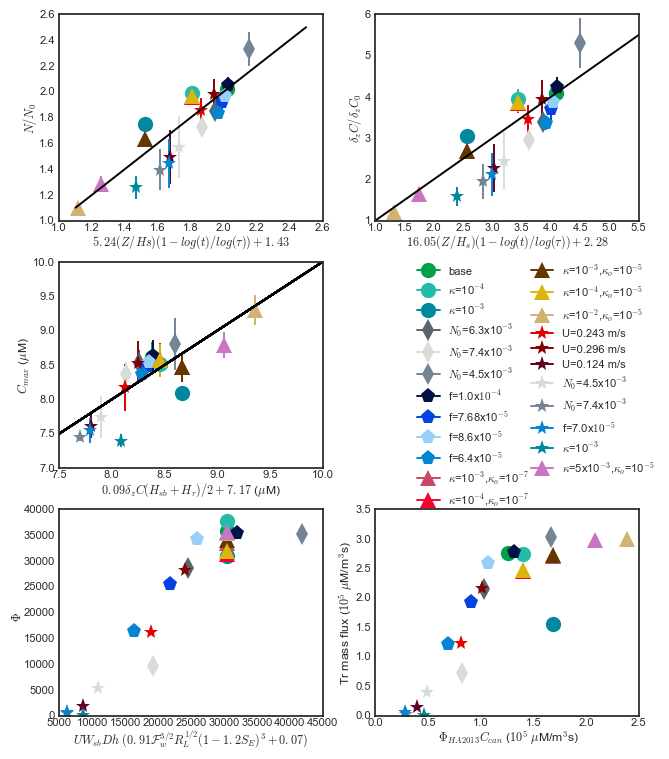

In [10]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.48,9.05)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

t=4 # days

# No

# dTr/dz
# ax.legend(bbox_to_anchor=(1.3,1)

# Tr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    #TauNo = 1-(0.7*t*24*3600*rec.kv/(((Hs-Hh)/2)**2))
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    #plt1 = ax0.errorbar((2.6*(Z/Hs)*(TauNo))+1.02,rec.maxN/rec.N,
    #                   yerr = rec.stdN/rec.N, # since rec.N is a constant
    #                   marker = rec.mstyle,
    #                   markersize = 11,
    #                   color = sns.xkcd_rgb[rec.color],
    #                   label=rec.label)
    plt1 = ax0.errorbar((5.24*(Z/Hs)*(TauNo))+1.43,rec.maxN/rec.N,
                       yerr = rec.stdN/rec.N, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = 11,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    
    
    
    rec.tauNo = TauNo 
    rec.Z = Z
    
    ax0.set_ylabel('$N/N_0$',labelpad=0.5)
    #ax0.set_xlabel(r'$2.6(Z/Hs)(1-0.7t/\tau)+1.02$',labelpad=0.5)
    ax0.set_xlabel(r'$5.24(Z/Hs)(1-log(t)/log(\tau))+1.43$',labelpad=0.5)

ax0.plot(np.linspace(1.1, 2.5, 50),np.linspace(1.1, 2.5, 50),'k-')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    plt1 = ax1.errorbar((16.05*((Z/Hs)*(TauNo)))+2.28,rec.maxdTrdz/rec.inidTrdz,
                       yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = 11,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    #ax1.set_title('Max $\delta_zC$ below Head depth Dn' )
    ax1.set_ylabel('$\delta_zC/\delta_zC_0$',labelpad=0.5)
    ax1.set_xlabel(r'$16.05(Z/H_s)(1-log(t)/log(\tau))+2.28$',labelpad=0.5)

ax1.plot(np.linspace(1,5.5, 50),np.linspace(1,5.5, 50),'k-')


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer Conc %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    #TauNo = 1-(0.45*t*24*3600*rec.kv/((((Hs-Hh)/2)**2)))
    ax2.plot(np.linspace(7.5,10.0,50),np.linspace(7.5,10,50),'k-')
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    plt1 = ax2.errorbar(0.09*(dTrdz*(Hh+132.0)/2.0)+7.17,rec.maxTr,
                   yerr = rec.stdTr,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)
   
    #ax2.set_title('Max tracer concetration between head nad sh, Dn')
    ax2.set_ylabel('$C_{max}$ ($\mu$M)',labelpad=0.5)
    ax2.set_xlabel(r'$0.09\delta_zC(H_{sb}+H_r)/2+7.17$ ($\mu$M)',labelpad=0.5)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t=4
for rec,recNoC in zip(records,recordsNoC):
    

    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    Napprox=((5.24*(Z/Hs)*(TauNo))+1.43)*rec.N
     
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCW-recNoC.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    #Phi = np.mean(np.array([(can_eff[ii]) for ii in range (8,14)]))
      
    plt1 = ax4.plot(HA2013*(rec.u*W*Dh(rec.f,L,rec.N)),
                    Phi,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)


    #ax4.set_title('Upwelling flux scaled as HA2013 using Napprox')
    ax4.set_ylabel('$\Phi$   ',labelpad=0.5)
    ax4.set_xlabel('$UW_{sb}Dh$ $(0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.2S_E)^3+0.07)$ ',labelpad=0.5)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec,recNoC in zip(records,recordsNoC):    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    #TauN = 1-((0.7*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauC = 1-((0.45*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauN = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    Napprox=((4.84*(Z/Hs)*(TauN))+1.49)*rec.N
    
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    Capprox=0.09*(dTrdz*(Hh+132.0)/2.0)+7.17
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,Napprox))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMass-recNoC.TrMass
    can_eff = rec.HCW-recNoC.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    #phiTr = np.mean(np.array([(mass_can_eff[ii]) for ii in range (8,14)]))
    
    #ax5.plot(np.linspace(0.5E8,3.0E8,50),np.linspace(0.5E8,3.0E8,50),'k-')
    plt1 = ax5.plot(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                    (phiTr/1E3)/1E5,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)
     
    #plt1 = ax5.plot(1000*phi*rec.maxTr, # 1000 is a conversion factor
    #                phiTr,
    #                marker = rec.mstyle,
    #                markersize = 11,
    #                color = sns.xkcd_rgb[rec.color],
    #                label=rec.label)

    #ax5.set_title('Tracer Mass upwelled scaled as $C \Phi_{HA2013}$, using N approx')
    ax5.set_xlabel(' $\Phi_{HA2013} C_{can}$ ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)
    ax5.set_ylabel('Tr mass flux ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)

    
ax5.legend(bbox_to_anchor=(1.1,2.25),ncol=2, columnspacing=0.1)
    
ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)
ax5.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
ax5.tick_params(axis='y', pad=3)

plt.savefig('fig_scaling_estimates.eps',format='eps',bbox_inches='tight')


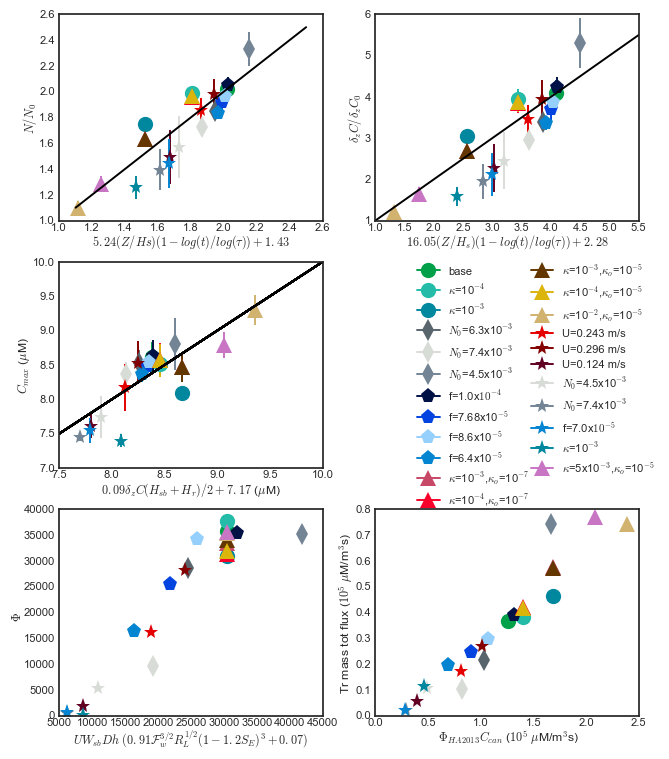

In [12]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.48,9.05)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

t=4 # days

# No

# dTr/dz
# ax.legend(bbox_to_anchor=(1.3,1)

# Tr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    #TauNo = 1-(0.7*t*24*3600*rec.kv/(((Hs-Hh)/2)**2))
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    #plt1 = ax0.errorbar((2.6*(Z/Hs)*(TauNo))+1.02,rec.maxN/rec.N,
    #                   yerr = rec.stdN/rec.N, # since rec.N is a constant
    #                   marker = rec.mstyle,
    #                   markersize = 11,
    #                   color = sns.xkcd_rgb[rec.color],
    #                   label=rec.label)
    plt1 = ax0.errorbar((5.24*(Z/Hs)*(TauNo))+1.43,rec.maxN/rec.N,
                       yerr = rec.stdN/rec.N, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = 11,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    
    
    
    rec.tauNo = TauNo 
    rec.Z = Z
    
    ax0.set_ylabel('$N/N_0$',labelpad=0.5)
    #ax0.set_xlabel(r'$2.6(Z/Hs)(1-0.7t/\tau)+1.02$',labelpad=0.5)
    ax0.set_xlabel(r'$5.24(Z/Hs)(1-log(t)/log(\tau))+1.43$',labelpad=0.5)

ax0.plot(np.linspace(1.1, 2.5, 50),np.linspace(1.1, 2.5, 50),'k-')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    plt1 = ax1.errorbar((16.05*((Z/Hs)*(TauNo)))+2.28,rec.maxdTrdz/rec.inidTrdz,
                       yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = 11,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    #ax1.set_title('Max $\delta_zC$ below Head depth Dn' )
    ax1.set_ylabel('$\delta_zC/\delta_zC_0$',labelpad=0.5)
    ax1.set_xlabel(r'$16.05(Z/H_s)(1-log(t)/log(\tau))+2.28$',labelpad=0.5)

ax1.plot(np.linspace(1,5.5, 50),np.linspace(1,5.5, 50),'k-')


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer Conc %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    #TauNo = 1-(0.45*t*24*3600*rec.kv/((((Hs-Hh)/2)**2)))
    ax2.plot(np.linspace(7.5,10.0,50),np.linspace(7.5,10,50),'k-')
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    plt1 = ax2.errorbar(0.09*(dTrdz*(Hh+132.0)/2.0)+7.17,rec.maxTr,
                   yerr = rec.stdTr,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)
   
    #ax2.set_title('Max tracer concetration between head nad sh, Dn')
    ax2.set_ylabel('$C_{max}$ ($\mu$M)',labelpad=0.5)
    ax2.set_xlabel(r'$0.09\delta_zC(H_{sb}+H_r)/2+7.17$ ($\mu$M)',labelpad=0.5)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t=4
for rec,recNoC in zip(records,recordsNoC):
    

    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    Napprox=((5.24*(Z/Hs)*(TauNo))+1.43)*rec.N
     
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCW-recNoC.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    #Phi = np.mean(np.array([(can_eff[ii]) for ii in range (8,14)]))
      
    plt1 = ax4.plot(HA2013*(rec.u*W*Dh(rec.f,L,rec.N)),
                    Phi,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)


    #ax4.set_title('Upwelling flux scaled as HA2013 using Napprox')
    ax4.set_ylabel('$\Phi$   ',labelpad=0.5)
    ax4.set_xlabel('$UW_{sb}Dh$ $(0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.2S_E)^3+0.07)$ ',labelpad=0.5)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec,recNoC in zip(records,recordsNoC):    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    #TauN = 1-((0.7*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauC = 1-((0.45*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauN = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    Napprox=((4.84*(Z/Hs)*(TauN))+1.49)*rec.N
    
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    Capprox=0.09*(dTrdz*(Hh+132.0)/2.0)+7.17
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,Napprox))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMassTot-recNoC.TrMassTot
    can_eff = rec.HCW-recNoC.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    #phiTr = np.mean(np.array([(mass_can_eff[ii]) for ii in range (8,14)]))
    
    #ax5.plot(np.linspace(0.5E8,3.0E8,50),np.linspace(0.5E8,3.0E8,50),'k-')
    plt1 = ax5.plot(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                    (phiTr/1E3)/1E5,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)
     
    #plt1 = ax5.plot(1000*phi*rec.maxTr, # 1000 is a conversion factor
    #                phiTr,
    #                marker = rec.mstyle,
    #                markersize = 11,
    #                color = sns.xkcd_rgb[rec.color],
    #                label=rec.label)

    #ax5.set_title('Tracer Mass upwelled scaled as $C \Phi_{HA2013}$, using N approx')
    ax5.set_xlabel(' $\Phi_{HA2013} C_{can}$ ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)
    ax5.set_ylabel('Tr mass tot flux ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)

    
ax5.legend(bbox_to_anchor=(1.1,2.25),ncol=2, columnspacing=0.1)
    
ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)
ax5.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
ax5.tick_params(axis='y', pad=3)

#plt.savefig('fig_scaling_estimates.eps',format='eps',bbox_inches='tight')
